In [1]:
import pandas as pd
import numpy as np
import os
import re
from scipy.io import arff
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from IPython.display import clear_output
import random

In [ ]:
# !unzip OpenML.zip

In [3]:
data_list = os.listdir('/content/data')
data_list = [int(item.replace('.arff','')) for item in data_list]
data_list.sort()
# data_list

In [4]:
data_list.pop(1)
data_list.pop(25)
data_list.pop(109)
data_list.pop(206)
data_list.pop(217)

543

In [77]:
data = arff.loadarff('/content/data/'+ str(data_list[0])+'.arff')
dff1 = pd.DataFrame(data[0])
cols = [col for col in dff1.columns if dff1[col].dtype=="O"]
dff1[cols]=dff1[cols].apply(lambda x: x.str.decode('utf8'))
dff1.head()

,family,product-type,steel,carbon,hardness,temper_rolling,condition,formability,strength,non-ageing,...,'s','p',shape,thick,width,len,oil,bore,packing,class
0,?,C,A,8.0,0.0,?,S,?,0.0,?,...,?,?,COIL,0.700,610.0,0.0,?,0,?,3
1,?,C,R,0.0,0.0,?,S,2,0.0,?,...,?,?,COIL,3.200,610.0,0.0,?,0,?,3
2,?,C,R,0.0,0.0,?,S,2,0.0,?,...,?,?,SHEET,0.700,1300.0,762.0,?,0,?,3
3,?,C,A,0.0,60.0,T,?,?,0.0,?,...,?,?,COIL,2.801,385.1,0.0,?,0,?,3
4,?,C,A,0.0,60.0,T,?,?,0.0,?,...,?,?,SHEET,0.801,255.0,269.0,?,0,?,3


In [6]:
# str(data[1:]).replace(r'\'s','').replace('\t','').split('\n')[1:-1]

Предобработка данных:

In [7]:
def preprocess_data(df1,data1):
  # определяем чиловые и категориальные признаки
  num = []
  cat = []
  lst = str(data1[1:]).replace('\t','').split('\n')[1:-1]
  for i in range(len(lst)):
    lst[i] = re.sub(r'\'s','',lst[i])
    if re.findall(r'numeric|nominal|data',lst[i])[0] =='numeric':
      num.append(df1.columns[i])
    else:
      cat.append(df1.columns[i])

  # меняем'?' на np.nan и обрабатываем nan
  df1 = df1.replace('?', np.nan)
  for column in df1.columns:
    if df1[column].isnull().sum()>=len(df1)/2:
      del df1[column]
      continue
    if df1[column].nunique() == 1:
      del df1[column]
      continue
    # замена на наиболее встречающееся для категориальных и среднее(.mean()/медиану(.median()) для числовых 
    if column in cat:
      df1[column] = df1[column].fillna(df1[column].mode().values[0])
    else: df1[column] = df1[column].fillna(df1[column].mean())
    # удаление строк с пропусками  
    # df = df.dropna()

  cat_cols = []
  num_cols = []
  for item in df1.columns:
    if item in cat:
      cat_cols.append(item)
    elif item in num:
      num_cols.append(item)
  return df1, num_cols, cat_cols

In [78]:
dfn, num, cat = preprocess_data(dff1,data)

In [9]:
def preprocess_for_train(df, cat_cols, num_cols):
  le = preprocessing.LabelEncoder()
  y = le.fit_transform(df.iloc[:,-1])
  # нормализация численных столбцов
  if num_cols !=[]:
    df_num = (df[num_cols]-df[num_cols].mean())/(df[num_cols].std())
  # ohe
  if cat_cols[:-1]!=[]:
    df_cat = pd.get_dummies(df[cat_cols[:-1]])
  if num_cols !=[] and cat_cols[:-1]!=[]:
    X = pd.concat([df_num,df_cat],axis =1)
  elif num_cols !=[]:
    X = df_num
  else:
    X = df_cat
  return X, y

## 2) Реализуйте несколько мета-признаков из каждой группы: базовые, статистические и структурные.

Базовые meta-признаки:

In [10]:
def base(df, cat_cols):
  if len(cat_cols)>1:
    return len(df),len(df.columns)-1,df.iloc[:,-1].nunique(),(len(cat_cols)-1)/(len(df.columns)-1)
  else:
    return len(df),len(df.columns)-1,df.iloc[:,-1].nunique(),0

In [11]:
def print_base(df,cat_cols):
  a,b,c,d = base(df, cat_cols)
  print('    количество объектов: ', a)
  print('    количество признаков: ', b)
  print('    количество классов: ', c)
  if len(cat_cols)>1:
    print('    доля категориальных признаков: ', d)

In [82]:
print_base(dfn, cat)

    количество объектов:  898
    количество признаков:  12
    количество классов:  5
    доля категориальных признаков:  0.5


Статистические meta-признаки:

In [13]:
import statistics as st
def stat(df, cat_cols, num_cols):
  le = preprocessing.LabelEncoder()
  y = le.fit_transform(df.iloc[:,-1])
  target = pd.DataFrame(y)
  cat_cols = cat_cols[:-1]
  max_num = []
  min_num = []
  skew_num = [] # коэффициент асимметрии
  num_cat = []
  pi = []
  tpi = []

  for column in df.columns:
    if column in cat_cols and len(cat_cols)>0:
      num_cat.append(df[column].nunique())
      for item in df[column].value_counts():
        pi.append(item/len(df))
    elif column in num_cols and num_cols!=[]:
      df[column] = (df[column]-df[column].mean())/(df[column].std())
      max_num.append(df[column].max())
      min_num.append(df[column].min())
      skew_num.append(df[column].skew())
  for item in target.value_counts():
    tpi.append(item/len(df))
  if len(cat_cols)>0 and num_cols!=[]:
    return min(max_num), max(max_num), min(min_num), max(min_num), min(skew_num), max(skew_num), min(num_cat), max(num_cat), min(pi), max(pi),max(tpi), min(tpi)
  elif max_num !=[] and min_num!=[] and skew_num!=[]:
    return min(max_num), max(max_num), min(min_num), max(min_num), min(skew_num), max(skew_num), 0, 0, 0, 0,max(tpi), min(tpi)
  elif num_cat !=[]:
    return 0, 0, 0, 0, 0, 0, min(num_cat), max(num_cat), min(pi), max(pi), max(tpi), min(tpi)

In [14]:
def print_statistic(df, cat_cols, num_cols):
    a,b,c,d,e,f,z,x,m,v,tc1,tc2 = stat(df, cat_cols, num_cols)
    print('    Для числовых столбцов: ')
    print('        MaxMin: ', a)
    print('        MaxMax: ', b)
    print('        MinMin: ', c)
    print('        MinMax: ', d)
    print('        SkewMin: ', e)
    print('        SkewMax: ', f)
    print('    Для категориальных столбцов: ')
    print('        Минимальное число категорий: ', z)
    print('        Максимальное число категорий: ', x)
    print('        Максимальная вероятность: ', v)
    print('        Минимальная вероятность: ', m)
    print('    Для таргетного столцба: ')
    print('        Максимальная вероятность',tc1)
    print('        Минимальная вероятность',tc2)

In [83]:
print_statistic(dfn, cat, num)

    Для числовых столбцов: 
        MaxMin:  1.8363255891119254
        MaxMax:  5.8224924019354445
        MinMin:  -1.9258952640649856
        MinMax:  -0.2649839589397371
        SkewMin:  0.0729904844208325
        SkewMax:  3.761601968915701
    Для категориальных столбцов: 
        Минимальное число категорий:  2
        Максимальное число категорий:  7
        Максимальная вероятность:  0.955456570155902
        Минимальная вероятность:  0.011135857461024499
    Для таргетного столцба: 
        Максимальная вероятность 0.7616926503340757
        Минимальная вероятность 0.008908685968819599


Структурные meta-признаки:

In [16]:
def d_tree(X, y):
  clf = DecisionTreeClassifier()
  clf.fit(X, y)
  return clf.get_n_leaves(), clf.get_depth()

In [17]:
def struct(df, cat_cols, num_cols):
  X, y = preprocess_for_train(df, cat_cols, num_cols)
  X_train, y_train = X.values, y
  return d_tree(X_train, y_train)

In [18]:
def print_struct(df, cat_cols, num_cols):
  a,b = struct(df, cat_cols, num_cols)
  print('    количество листов: ', a)
  print('    максимальная глубина дерева: ', b)

In [84]:
print_struct(dfn, cat, num)

    количество листов:  79
    максимальная глубина дерева:  18


## 3) Выберите один набор данных. Измените в нём порядок строк, столбцов и категорий. Убедитесь, что мета-признаки от этого не изменились.

In [85]:
# перемешиваем столбцы
columns = dfn.columns.to_list()
last = columns[-1]
features = columns[:-1]
random.shuffle(features)
new_df = dfn[features+[last]]
# перемешиваем строки
new_df.loc[::-1]
new_df.reset_index(drop=True)
new_df.head()

,bore,carbon,shape,width,surface-quality,hardness,formability,len,steel,strength,thick,condition,class
0,0,0.318241,COIL,-0.421007,G,-0.475795,2,-0.674947,A,-0.266781,-0.572250,S,3
1,0,-0.264984,COIL,-0.421007,E,-0.475795,2,-0.674947,R,-0.266781,2.297328,S,3
2,0,-0.264984,SHEET,1.281244,E,-0.475795,2,-0.267765,R,-0.266781,-0.572250,S,3
3,0,-0.264984,COIL,-0.975842,G,1.948396,2,-0.674947,A,-0.266781,1.839343,S,3
4,0,-0.264984,SHEET,-1.296803,G,1.948396,2,-0.531204,A,-0.266781,-0.456319,S,3


In [86]:
print('Базовые мета-признаки')
print_base(dfn,cat)
print('Статистические мета-признаки')
print_statistic(dfn, cat, num)
print('Структурные мета-признаки')
print_struct(dfn, cat, num)

Базовые мета-признаки
    количество объектов:  898
    количество признаков:  12
    количество классов:  5
    доля категориальных признаков:  0.5
Статистические мета-признаки
    Для числовых столбцов: 
        MaxMin:  1.8363255891119254
        MaxMax:  5.8224924019354445
        MinMin:  -1.9258952640649856
        MinMax:  -0.2649839589397371
        SkewMin:  0.0729904844208325
        SkewMax:  3.761601968915701
    Для категориальных столбцов: 
        Минимальное число категорий:  2
        Максимальное число категорий:  7
        Максимальная вероятность:  0.955456570155902
        Минимальная вероятность:  0.011135857461024499
    Для таргетного столцба: 
        Максимальная вероятность 0.7616926503340757
        Минимальная вероятность 0.008908685968819599
Структурные мета-признаки
    количество листов:  79
    максимальная глубина дерева:  18


In [87]:
print('Базовые мета-признаки')
print_base(new_df,cat)
print('Статистические мета-признаки')
print_statistic(new_df, cat, num)
print('Структурные мета-признаки')
print_struct(new_df, cat, num)

Базовые мета-признаки
    количество объектов:  898
    количество признаков:  12
    количество классов:  5
    доля категориальных признаков:  0.5
Статистические мета-признаки
    Для числовых столбцов: 
        MaxMin:  1.8363255891119254
        MaxMax:  5.8224924019354445
        MinMin:  -1.9258952640649856
        MinMax:  -0.2649839589397371
        SkewMin:  0.0729904844208325
        SkewMax:  3.761601968915701
    Для категориальных столбцов: 
        Минимальное число категорий:  2
        Максимальное число категорий:  7
        Максимальная вероятность:  0.955456570155902
        Минимальная вероятность:  0.011135857461024499
    Для таргетного столцба: 
        Максимальная вероятность 0.7616926503340757
        Минимальная вероятность 0.008908685968819599
Структурные мета-признаки
    количество листов:  79
    максимальная глубина дерева:  18


## 4) Выберите не менее трёх алгоритмов обучения с учителем и меру оценки алгоритма обучения (валидацию).
## 5) Постройте мета-набор данных. Для каждого набора данных определите наилучший алгоритм для него.


Были выбраны такие алгоритмы как: Метод ближайших соседей, логистическая регрессия и  случайный лес

Мера оценки - f1-score

In [23]:
def make_meta_df(set_df, with_best=True):
  set_methods = ['knn', 'log_reg', 'random_forest']
  score = 'micro'
  # собираем датасет
  if with_best:
    meta_df = pd.DataFrame(columns=['num_obj', 'num_features', 'num_cls', 'share_cat_features','MaxMin','MaxMax','MinMin','MinMax','SkewMin',
                                  'SkewMax','min_num_cat','max_num_cat', 'max_pi', 'min_pi', 'max_tpi', 'min_tpi','n_leaves','max_depth',' best'])
  else:
    meta_df = pd.DataFrame(columns=['num_obj', 'num_features', 'num_cls', 'share_cat_features','MaxMin','MaxMax','MinMin','MinMax','SkewMin',
                                  'SkewMax','min_num_cat','max_num_cat', 'max_pi', 'min_pi', 'max_tpi', 'min_tpi','n_leaves','max_depth'])
  for item in set_df:
    dt = arff.loadarff('/content/data/'+ str(item)+'.arff')
    dff = pd.DataFrame(dt[0])
    all_cols = [col for col in dff.columns if dff[col].dtype=="O"]
    dff[all_cols]=dff[all_cols].apply(lambda x: x.str.decode('utf8'))
    new_df, num, cat = preprocess_data(dff,dt)
    row = []
    b = base(new_df, cat)
    stats = stat(new_df, cat, num)
    structs = struct(new_df, cat, num)
    for i in range(18):
      if i < 4:
        row.append(b[i])
      elif i>=4 and i<16:
        row.append(stats[i-4])
      elif i >=16:
        row.append(structs[i-16])

    if with_best:
      # выбираем наилучшие алгоритмы
      X, y = preprocess_for_train(new_df, cat, num)
      X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
      scores = []
      if len(np.unique(y)) == 2:
        score = 'binary'
      else:
        score = 'micro'
      print(item)
      knn=KNeighborsClassifier(n_neighbors=3)
      knn.fit(X_train,y_train)
      pred_knn = knn.predict(X_test)
      scores.append(f1_score(y_test, pred_knn, average=score))
      clear_output(wait=True)

      log_reg = LogisticRegression()
      log_reg.fit(X_train,y_train)
      pred_lr = log_reg.predict(X_test)
      scores.append(f1_score(y_test, pred_lr, average=score))
      clear_output(wait=True)

      forest = DecisionTreeClassifier()
      forest.fit(X_train,y_train)
      pred_f = forest.predict(X_test)
      scores.append(f1_score(y_test, pred_f, average=score))
      clear_output(wait=True)
      row.append(set_methods[scores.index(max(scores))])
    meta_df.loc[len(meta_df.index)] = row  

  return meta_df

In [66]:
meta_set = make_meta_df(data_list[:300])

653


In [67]:
meta_set.head()

,num_obj,num_features,num_cls,share_cat_features,MaxMin,MaxMax,MinMin,MinMax,SkewMin,SkewMax,min_num_cat,max_num_cat,max_pi,min_pi,max_tpi,min_tpi,n_leaves,max_depth,best
0,898,12,5,0.500000,1.836326,5.822492,-1.925895,-0.264984,0.072990,3.761602,2,7,0.011136,0.955457,0.761693,0.008909,81,18,random_forest
1,57,11,2,0.454545,0.828158,6.052042,-4.662530,-1.327812,-2.115151,4.395078,2,3,0.052632,0.947368,0.649123,0.350877,9,5,log_reg
2,226,68,24,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,6,0.004425,0.995575,0.252212,0.004425,51,13,log_reg
3,345,6,2,0.000000,2.886759,6.590714,-5.656222,-0.847902,-0.388433,3.063499,0,0,0.000000,0.000000,0.579710,0.420290,78,9,log_reg
4,205,25,6,0.400000,2.253140,4.780975,-3.780084,-0.791164,-0.689784,2.610862,2,22,0.004878,0.985366,0.326829,0.014634,39,9,random_forest


In [72]:
meta_set.iloc[:,-1].value_counts()

knn              150
random_forest    104
log_reg           46
Name:  best, dtype: int64

## 6) Визуализируйте мета-набор данных проекцией на двумерном графике. Используйте разные цвета для разных мета-классов.

In [26]:
le=LabelEncoder()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


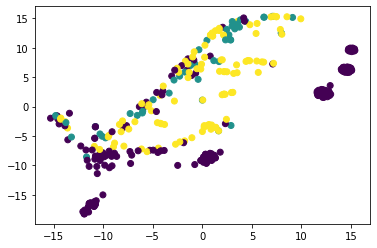

In [88]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
X = meta_set.iloc[:,:-1]
y = meta_set.iloc[:,-1]
y = le.fit_transform(y)
# pca = PCA(n_components=2)
# components = pca.fit_transform(X)
tsne = TSNE(n_components=2)
components = tsne.fit_transform(X)
components_x = [item[0] for item in components]
components_y = [item[1] for item in components]
plt.scatter(components_x,components_y, c = y)
plt.show()

## 7) Протестируйте несколько алгоритмов обучения с учителем (включая наивный алгоритм) на полученном наборе данных.

In [69]:
X = meta_set.iloc[:,:-1]
y = meta_set.iloc[:,-1]
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)


In [75]:
parameters = {'C':[100, 10, 1, 0.1, 0.01, 0.001]}
log_reg = GridSearchCV(
        estimator = LogisticRegression(max_iter=1000),
        param_grid = parameters,
        scoring = 'f1_micro',
        verbose=10
      )
log_reg.fit(X_train,y_train)
pred_lr = log_reg.predict(X_test)
clear_output(wait=True)
f1_score(y_test, pred_lr, average='micro')

0.7733333333333333

In [76]:
# наивный алгоритм
model = np.argmax(np.bincount(y_train))
pred = [model]*len(y_test)
f1_score(y_test, pred, average='micro')

0.44